<a href="https://colab.research.google.com/github/lazysimon/NYCDSA_CapstoneProject/blob/master/als_revised1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Spark (2.4.4) and findspark

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://mirror.its.dal.ca/apache/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xvf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

spark-2.4.4-bin-hadoop2.7/
spark-2.4.4-bin-hadoop2.7/R/
spark-2.4.4-bin-hadoop2.7/R/lib/
spark-2.4.4-bin-hadoop2.7/R/lib/sparkr.zip
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/INDEX
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/R.css
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/00Index.html
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/aliases.rds
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/AnIndex
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/SparkR.rdx
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/SparkR.rdb
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/paths.rds
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/worker.R
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/daemon.R
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/testthat/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/testthat/te

# Importing Neccessary Packages

In [0]:
# time
import time

# os 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

# data science imports
import math
import numpy as np
import pandas as pd


#from scipy.sparse import csr_matrix
#from urllib.request import urlopen

# utils import
#!pip install fuzzywuzzy
#from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import findspark
findspark.init()

from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext, Row
from pyspark.sql.functions import UserDefinedFunction, explode, desc, col, lower, lit
from pyspark.sql.types import StringType, ArrayType

from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

spark = SparkSession.builder.master("local[*]").getOrCreate()

%matplotlib inline

In [0]:
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
# mergeSQL = sqlContext.createDataFrame(mergeDF)

# Loading the Datasets

In [4]:
### loading the movie dataset
movie_fname = 'https://raw.githubusercontent.com/lazysimon/NYCDSA_CapstoneProject/master/latest/movies.dat'
movieDF = pd.read_csv(movie_fname, sep='::', header='infer', skipinitialspace=True,names = ["MovieId","Movie_Title","Genres"])
movieDF = movieDF.drop('Genres', 1)

### loading the rating dataset
rating_fname = 'https://raw.githubusercontent.com/lazysimon/NYCDSA_CapstoneProject/master/latest/ratings.dat'
ratingDF = pd.read_csv(rating_fname, sep='::', header='infer', skipinitialspace=True,names = ["UserId", "MovieId", "Rating", "Timestamp"])
ratingDF = ratingDF.drop('Timestamp',1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


In [5]:
### print the first five rows of the two datasets
print(movieDF.head(5))
print(ratingDF.head(5))

   MovieId                                        Movie_Title
0        8      Edison Kinetoscopic Record of a Sneeze (1894)
1       10                La sortie des usines Lumière (1895)
2       12                      The Arrival of a Train (1896)
3       25  The Oxford and Cambridge University Boat Race ...
4       91                         Le manoir du diable (1896)
   UserId  MovieId  Rating
0       1   111161      10
1       1   117060       7
2       1   120755       6
3       1   317919       6
4       1   454876      10


In [0]:
### convert the dataframes to spark.RDD
ratingRDD = sqlContext.createDataFrame(ratingDF)
ratingRDD = ratingRDD.selectExpr("UserId as user","MovieId as item","Rating as rating")

movieRDD = sqlContext.createDataFrame(movieDF)
movieRDD = movieRDD.selectExpr("MovieId as item","Movie_title as title")

In [7]:
print("Number of movies: {}".format(movieRDD.count()))
print("Number of ratings: {}".format(ratingRDD.count()))
print("Number of users: {}".format(ratingRDD.select('user').distinct().count()))

Number of movies: 34000
Number of ratings: 801291
Number of users: 59168


In [8]:
### print the first five rows of the two RDDs
print(ratingRDD.show())
print(movieRDD.show())

+----+-------+------+
|user|   item|rating|
+----+-------+------+
|   1| 111161|    10|
|   1| 117060|     7|
|   1| 120755|     6|
|   1| 317919|     6|
|   1| 454876|    10|
|   1| 790724|     8|
|   1| 882977|     8|
|   1|1229238|     9|
|   1|1288558|     5|
|   1|1300854|     8|
|   1|1483013|     6|
|   1|1583421|     7|
|   1|1588173|     9|
|   1|1711425|     3|
|   1|2024432|     8|
|   1|2053463|     8|
|   1|2101341|     7|
|   1|2101441|     1|
|   1|2302755|    10|
|   2| 422720|     8|
+----+-------+------+
only showing top 20 rows

None
+----+--------------------+
|item|               title|
+----+--------------------+
|   8|Edison Kinetoscop...|
|  10|La sortie des usi...|
|  12|The Arrival of a ...|
|  25|The Oxford and Ca...|
|  91|Le manoir du diab...|
| 131|Une nuit terrible...|
| 417|Le voyage dans la...|
| 439|The Great Train R...|
| 443|Hiawatha, the Mes...|
| 628|The Adventures of...|
| 833|The Country Docto...|
|1223| Frankenstein (1910)|
|1740|The Lonedale Op

In [0]:
def split_sets(ratings, proportions):
    split = ratings.randomSplit(proportions, seed=42)
    return {'training': split[0], 'validation': split[1], 'test': split[2]}
  
def calc_se(rating, user_factor, item_factor):
    """Squared Error (SE) for a single rating and prediction"""
    prediction = user_factor.T.dot(item_factor)
    return (rating - prediction) ** 2

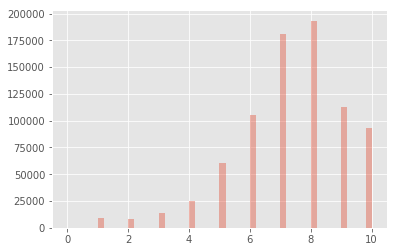

In [10]:
import seaborn as sns

r = ratingRDD.select('rating').collect()
sns.distplot(r, kde=False)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


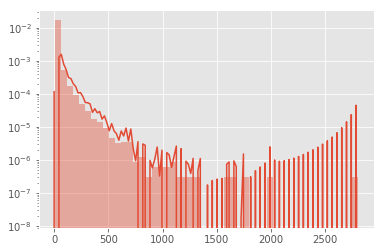

In [11]:
ratings_per_user = ratingRDD.groupBy("user").count()
sns.distplot(ratings_per_user.select("count").collect(), hist_kws={'log':True}, kde_kws={'clip': (1.0, 3000.0)})

In [12]:
sets = split_sets(ratingRDD, [0.63212056, 0.1839397, 0.1839397])
print("Training dataset size = {}".format(sets['training'].count()))
print("Validation dataset size = {}".format(sets['validation'].count()))
print("Test dataset size = {}".format(sets['test'].count()))

Training dataset size = 506226
Validation dataset size = 148042
Test dataset size = 147023


In [13]:
ratings_per_user.filter(col('count') > 1000).groupBy('user').count().agg({"count":"sum"}).show()

+----------+
|sum(count)|
+----------+
|        14|
+----------+



In [14]:
ratings_per_user.filter(col('count') < 100).groupBy('user').count().agg({"count":"sum"}).show()

+----------+
|sum(count)|
+----------+
|     57554|
+----------+



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


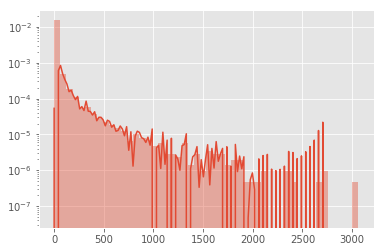

In [16]:
ratings_per_movie = ratingRDD.groupBy("item").count()
sns.distplot(ratings_per_movie.select("count").collect(), hist_kws={'log':True}, kde_kws={'clip': (0, 3000.0)})

In [17]:
ratings_per_movie.filter(col('count') < 2).groupBy('item').count().agg({"count":"sum"}).show()

+----------+
|sum(count)|
+----------+
|     14300|
+----------+



In [18]:
sets['training'].show(10)

+----+-------+------+
|user|   item|rating|
+----+-------+------+
|   1| 454876|    10|
|   1| 790724|     8|
|   1| 882977|     8|
|   1|1229238|     9|
|   1|1288558|     5|
|   1|1483013|     6|
|   1|1583421|     7|
|   1|1588173|     9|
|   1|2024432|     8|
|   1|2053463|     8|
+----+-------+------+
only showing top 10 rows



In [19]:
### Parameter tuning
als = ALS(coldStartStrategy="drop")

param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [6, 8]) \
    .addGrid(als.maxIter,[10, 12]) \
    .build()

evaluator = RegressionEvaluator(
    metricName="mse",
    labelCol="rating",
    predictionCol="prediction")

tvs = TrainValidationSplit(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
)

%time model = tvs.fit(sets['training'])

print("Best rank = {}".format(model.bestModel.rank))
print("Best maxIter = {}".format(model.bestModel._java_obj.parent().getMaxIter()))

CPU times: user 651 ms, sys: 142 ms, total: 793 ms
Wall time: 1min 40s
Best rank = 6
Best maxIter = 12


In [20]:
from pyspark.sql.functions import col
prediction = model.transform(sets['test'])
# movieRDD = movieRDD.selectExpr("UserId as user","MovieId as item","Rating as rating")

prediction.alias('p').join(movieRDD.alias('m'), col('p.item') == col('m.item')) \
    .select([col('p.user'), col('m.title'), col('p.prediction'), col('p.rating')]).show(100, truncate=False)

+-----+--------------------------------------+----------+------+
|user |title                                 |prediction|rating|
+-----+--------------------------------------+----------+------+
|21563|Only Angels Have Wings (1939)         |4.6387353 |9     |
|41579|The Lost Weekend (1945)               |7.7722406 |9     |
|27802|The Lost Weekend (1945)               |7.8332944 |8     |
|30478|The Lost Weekend (1945)               |8.908277  |9     |
|10478|The Lost Weekend (1945)               |10.058904 |9     |
|41281|Lady and the Tramp (1955)             |6.1701107 |7     |
|3833 |Lady and the Tramp (1955)             |8.620272  |9     |
|58043|Lady and the Tramp (1955)             |7.4901013 |7     |
|40048|Lady and the Tramp (1955)             |7.7559667 |9     |
|37987|Lady and the Tramp (1955)             |7.8550167 |3     |
|17310|Lady and the Tramp (1955)             |8.435482  |8     |
|36036|Lady and the Tramp (1955)             |7.44176   |8     |
|58054|The Blob (1958)   

(0, 10)

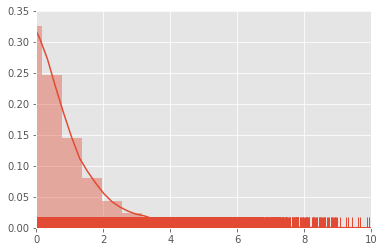

In [21]:
errors = prediction.withColumn('error', col('prediction')-col('rating')).select('error').collect()
ax = sns.distplot(errors, rug=True, hist=True)
ax.set_xlim(0, 10)

In [23]:
mse = evaluator.evaluate(prediction)
print("MSE = {}".format(mse))

MSE = 2.662087108654272


In [24]:
# top 10 movies for all users
k = 10 
model.bestModel.recommendForAllUsers(k).show(10)

KeyboardInterrupt: ignored

In [0]:
# top 10 users for all movies
model.bestModel.recommendForAllItems(k).show(10)

In [25]:
user59169 = ratingRDD.groupBy().max('user').first()['max(user)'] + 1
print("New user id = {}".format(user59169)) # 59168 users

New user id = 59169


In [0]:
from pyspark.sql.functions import lower

def find_movie_id(partial_title):
    movieRDD.where(lower(col('title')).like("%{}%".format(partial_title.lower())))\
    .show(truncate=False)

In [0]:
print(find_movie_id('one day'))
print(find_movie_id('avengers'))

+-------+-------------------------+
|item   |title                    |
+-------+-------------------------+
|1563738|One Day (2011)           |
|1900946|One Day on Earth (2012)  |
|5598320|One Day I'll Leave (2015)|
|6168298|One Day (2016)           |
|6214734|One Day (2017)           |
+-------+-------------------------+

None
+-------+-------------------------------------+
|item   |title                                |
+-------+-------------------------------------+
|118661 |The Avengers (1998)                  |
|848228 |The Avengers (2012)                  |
|2395427|Avengers: Age of Ultron (2015)       |
|4154756|Avengers: Infinity War (2018)        |
|4154796|Avengers: Endgame (2019)             |
|4296026|Avengers Grimm (2015)                |
|5262972|Avengers: Age of Ultron Parody (2015)|
+-------+-------------------------------------+

None


In [74]:
find_movie_id('Crouching')

+-------+-------------------------------------------------------+
|item   |title                                                  |
+-------+-------------------------------------------------------+
|2652118|Crouching Tiger, Hidden Dragon: Sword of Destiny (2016)|
+-------+-------------------------------------------------------+



In [61]:
from pyspark.sql import Row
rating59169 = [
    (118661, 1), # Avengers
    (371746, 1),  # Iron Man 2008
    #(397535, 6),  Memoirs of a Geisha
    #(94625, 9),  Akira
    (1563738, 9), # One day 2011
    (800369, 1),  # Thor
    #(1981115, 9),  Thor: The Dark World
    #(3501632, 9),  Thor: Ragnarok
    (120338, 9), # Titanic
    (98635, 9), # When Harry Met Sally
    (125439, 9), # Notting Hill
    (332280, 9) # The Notebook
]
user59169DF = spark.createDataFrame([Row(user=user59169, item=r[0], rating=r[1]) for r in rating59169])
user59169DF.show()

+-------+------+-----+
|   item|rating| user|
+-------+------+-----+
| 118661|     1|59169|
| 371746|     1|59169|
|1563738|     9|59169|
| 800369|     1|59169|
| 120338|     9|59169|
|  98635|     9|59169|
| 125439|     9|59169|
| 332280|     9|59169|
+-------+------+-----+



In [62]:
user59169DF = user59169DF.select('user','item','rating')
user59169DF.show()
type(user59169DF)

+-----+-------+------+
| user|   item|rating|
+-----+-------+------+
|59169| 118661|     1|
|59169| 371746|     1|
|59169|1563738|     9|
|59169| 800369|     1|
|59169| 120338|     9|
|59169|  98635|     9|
|59169| 125439|     9|
|59169| 332280|     9|
+-----+-------+------+



pyspark.sql.dataframe.DataFrame

In [63]:
ratingRDD2 = ratingRDD.union(user59169DF)
ratingRDD2.groupBy().max('user').first()['max(user)'] + 1
user59170 = ratingRDD2.groupBy().max('user').first()['max(user)'] + 1
print("New user id = {}".format(user59170)) # 59168 users

New user id = 59170


In [64]:
best_rank = model.bestModel.rank
best_iterations = model.bestModel._java_obj.parent().getMaxIter()
%time new_model = ALS(rank=best_rank, maxIter=best_iterations, coldStartStrategy="drop").fit(ratingRDD2)

CPU times: user 64.4 ms, sys: 11.8 ms, total: 76.3 ms
Wall time: 11.2 s


In [65]:
unseen_movies = movieRDD.alias('m').join(user59169DF.alias('r'), col('m.item') == col('r.item'), how='left_anti').select('item')
unseen_movies.show(10)
print("Number of unseen movies = {}".format(unseen_movies.count()))

+-----+
| item|
+-----+
| 9968|
|31762|
|37098|
|37884|
|38108|
|38510|
|48280|
|49967|
|51418|
|54415|
+-----+
only showing top 10 rows

Number of unseen movies = 33992


In [66]:
from pyspark.sql.functions import lit

unseen_movies_user = unseen_movies.withColumn("user", lit(user59169))
unseen_movies_user.show()

+-----+-----+
| item| user|
+-----+-----+
| 9968|59169|
|31762|59169|
|37098|59169|
|37884|59169|
|38108|59169|
|38510|59169|
|48280|59169|
|49967|59169|
|51418|59169|
|54415|59169|
|61135|59169|
|61597|59169|
|64757|59169|
|64873|59169|
|65462|59169|
|65848|59169|
|66070|59169|
|66580|59169|
|67148|59169|
|69976|59169|
+-----+-----+
only showing top 20 rows



In [67]:
unseen_movies.show()

+-----+
| item|
+-----+
| 9968|
|31762|
|37098|
|37884|
|38108|
|38510|
|48280|
|49967|
|51418|
|54415|
|61135|
|61597|
|64757|
|64873|
|65462|
|65848|
|66070|
|66580|
|67148|
|69976|
+-----+
only showing top 20 rows



In [68]:
spark.conf.set("spark.sql.crossJoin.enabled", "true")
unseen_ratings = new_model.transform(unseen_movies_user)
unseen_ratings.show(10)

+-----+-----+----------+
| item| user|prediction|
+-----+-----+----------+
|  833|59169| 3.4568524|
| 4101|59169|  6.415948|
| 7880|59169|  7.074723|
|18051|59169| 11.068591|
|19079|59169| 4.9347243|
|25591|59169|  5.830441|
|31951|59169| 6.6725464|
|31983|59169| 3.4951837|
|33717|59169| 7.4767804|
|40335|59169| 10.288864|
+-----+-----+----------+
only showing top 10 rows



In [69]:
unseen_ratings_titles = unseen_ratings.alias('r')\
                        .join(movieRDD.alias('m'), col('r.item') == col('m.item'))\
                        .select(['user', 'title', 'prediction'])


unseen_ratings_titles.show(10, truncate=False) ##lmao exceeds max rating

+-----+-----------------------------------------------------+----------+
|user |title                                                |prediction|
+-----+-----------------------------------------------------+----------+
|59169|Broken Blossoms or The Yellow Man and the Girl (1919)|7.352794  |
|59169|Only Angels Have Wings (1939)                        |2.7933717 |
|59169|The Mummy's Curse (1944)                             |3.9477797 |
|59169|The Lost Weekend (1945)                              |11.016023 |
|59169|The Spanish Main (1945)                              |3.8310013 |
|59169|Enamorada (1946)                                     |7.104987  |
|59169|Lady and the Tramp (1955)                            |6.545324  |
|59169|X: The Unknown (1956)                                |6.3368883 |
|59169|The Blob (1958)                                      |7.373987  |
|59169|12 to the Moon (1960)                                |0.36766136|
+-----+--------------------------------------------

In [70]:
unseen_ratings_titles.orderBy(col('prediction').desc()).show(20)

+-----+--------------------+----------+
| user|               title|prediction|
+-----+--------------------+----------+
|59169|Dante's Hell Anim...| 23.626059|
|59169|   Loose Ends (1975)| 22.347765|
|59169| King's Faith (2013)| 21.303312|
|59169|   Warfighter (2018)| 21.024208|
|59169|Goreyan Nu Daffa ...| 20.635515|
|59169|Quiet Riot: Well ...| 20.536964|
|59169|Mysterious & Ways...| 19.992966|
|59169|God's Country (2012)| 19.992966|
|59169|Scotland's Caddie...| 19.970066|
|59169|La Buona Uscita (...| 19.916574|
|59169|Meitantei Conan: ...| 19.242386|
|59169|Dil Hai Tumhaara ...| 19.133154|
|59169|She Could Be You ...| 19.115402|
|59169|Welcome to Hard T...| 19.086384|
|59169|The Congressman (...|  18.90662|
|59169|Sacred Whispers (...|  18.85846|
|59169|War Time Falcon (...|  18.70407|
|59169|  Girl Asleep (2015)| 18.532167|
|59169|The Kings of York...| 18.309933|
|59169|On a Clear Day Yo...| 18.234306|
+-----+--------------------+----------+
only showing top 20 rows



In [71]:
ratings_per_movie = ratingRDD.groupBy('item').count()
enough_ratings = ratings_per_movie.filter(col('count') < 1000)
enough_ratings.show()

+-------+-----+
|   item|count|
+-------+-----+
|1972571|  377|
|  97216|   71|
|1360860|  132|
| 796366|  321|
|1477834|  742|
|3967856|  284|
|1640711|   16|
| 803096|  510|
|5177088|   68|
|1600524|   34|
|3174376|   84|
|1772264|  103|
|3658772|   45|
|1131734|   48|
| 462335|   93|
|5112966|    1|
|4005402|  187|
|1259528|  211|
|1243974|  137|
|1028576|   13|
+-------+-----+
only showing top 20 rows



In [72]:
training_100 = unseen_ratings.alias('r')\
    .join(enough_ratings.alias('e'), col('r.item') == col('e.item'), how='left_anti')\
    .select(['item', 'user', 'prediction']).orderBy(col('prediction').desc())
training_100.show()

+-------+-----+----------+
|   item| user|prediction|
+-------+-----+----------+
|1065073|59169| 10.969501|
|3783958|59169| 10.527392|
|5013056|59169|10.0908375|
|1798709|59169| 10.078356|
|7131622|59169| 9.7695875|
|1817273|59169|  9.750026|
|1245492|59169| 9.6377735|
|4034228|59169|  9.607753|
|2562232|59169|  9.557329|
|1454468|59169|   9.45428|
|2179136|59169|  9.380782|
|2543164|59169|  9.279258|
|2488496|59169|  8.966662|
|1895587|59169|   8.82448|
|2024544|59169| 8.7087345|
| 359950|59169|  8.389807|
|3890160|59169|  8.303661|
|2278388|59169|  8.273398|
| 470752|59169| 8.2387085|
|2582802|59169| 8.1600275|
+-------+-----+----------+
only showing top 20 rows



In [73]:
training_100.alias('t').join(movieRDD.alias('m'), col('t.item') == col('m.item')) \
    .select(['user', 'title', 'prediction']).orderBy(col('prediction').desc()).show(100, truncate=False)

+-----+------------------------------------------------+----------+
|user |title                                           |prediction|
+-----+------------------------------------------------+----------+
|59169|Boyhood (2014)                                  |10.969501 |
|59169|La La Land (2016)                               |10.527392 |
|59169|Dunkirk (2017)                                  |10.0908375|
|59169|Her (2013)                                      |10.078356 |
|59169|Once Upon a Time ... in Hollywood (2019)        |9.7695875 |
|59169|The Place Beyond the Pines (2012)               |9.750026  |
|59169|This Is the End (2013)                          |9.6377735 |
|59169|Manchester by the Sea (2016)                    |9.607753  |
|59169|Birdman (2014)                                  |9.557329  |
|59169|Gravity (2013)                                  |9.45428   |
|59169|American Sniper (2014)                          |9.380782  |
|59169|Arrival (2016)                           